## Math 156 Extra Credit


### Sentiment Analysis, Hyperparameter Optimization, and Model Comparison

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
import math
from nrclex import NRCLex 
import re
from nltk.tokenize import word_tokenize
import nltk
from itertools import chain
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from scipy.stats import loguniform
from sklearn import svm

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Goal: predict the number of stars in the review from the data.\
We will be using sentiment analysis to see whether we can predict the number of stars from the text review.
Dataset can be downloaded from: https://www.kaggle.com/datasets/whenamancodes/amazon-reviews-on-women-dresses?resource=download

In [3]:
# Pre-processing
# ratings_Books.csv can be found in the GitHub
ratings = pd.read_csv("WomensDressReviews.csv", delimiter=',', header = 0)
ratings.head()

,s.no,age,division_name,department_name,class_name,clothing_id,title,review_text,alike_feedback_count,rating,recommend_index
0,0,40,General,Bottoms,Jeans,1028,Amazing fit and wash,Like other reviewers i was hesitant to spend t...,0,5,1
1,1,62,General Petite,Tops,Blouses,850,Lovely and unique!,As is true of a bunch of the fall clothing pho...,12,5,1
2,2,47,General Petite,Bottoms,Skirts,993,Meh,"I so wanted this skirt to work, love the desig...",3,1,0
3,3,45,General Petite,Bottoms,Pants,1068,Wow,Love love this! i was hesitant to buy this at ...,0,5,1
4,4,37,Initmates,Intimate,Swim,24,Great for bigger busts,I absolutely love the retro look of this swims...,0,5,1


For simplicity, we can reduce the dataset to the review text and the rating, the two relevant features of this dataset.

In [4]:
ratings = ratings[['review_text', 'rating']]
ratings.head()

,review_text,rating
0,Like other reviewers i was hesitant to spend t...,5
1,As is true of a bunch of the fall clothing pho...,5
2,"I so wanted this skirt to work, love the desig...",1
3,Love love this! i was hesitant to buy this at ...,5
4,I absolutely love the retro look of this swims...,5


We will now clean our reviews by reducing them down to the key words that convey the sentiment of the user. First, we remove puncutation and reduce the review down to its core words. We do this using the $re.sub$ package that uses regular expression operations to remove puncutation and leave just the text.

In [5]:
def remove_punct(review):
    review = re.sub('[^A-Za-z]+', ' ', str(review))
    return review

In [6]:
ratings['Cleaned Reviews'] = ratings['review_text'].apply(remove_punct)

In [7]:
ratings.head()

,review_text,rating,Cleaned Reviews
0,Like other reviewers i was hesitant to spend t...,5,Like other reviewers i was hesitant to spend t...
1,As is true of a bunch of the fall clothing pho...,5,As is true of a bunch of the fall clothing pho...
2,"I so wanted this skirt to work, love the desig...",1,I so wanted this skirt to work love the design...
3,Love love this! i was hesitant to buy this at ...,5,Love love this i was hesitant to buy this at f...
4,I absolutely love the retro look of this swims...,5,I absolutely love the retro look of this swims...


Now we will tokenize our data by breaking it down into categories. Since we are trying to extract sentiments from the reviews, we will be doing work tokeniation using the function $\textit{word_tokenize}$ from the $\textit{nltk tokenize}$ package.

In [8]:
tokenized_review = []
for i in range(len(ratings['Cleaned Reviews'])):
     tokenized_review.append(word_tokenize(ratings['Cleaned Reviews'][i]))
# for i in range()

In [9]:
ratings['tokenized_review'] = tokenized_review
ratings.head()

,review_text,rating,Cleaned Reviews,tokenized_review
0,Like other reviewers i was hesitant to spend t...,5,Like other reviewers i was hesitant to spend t...,"[Like, other, reviewers, i, was, hesitant, to,..."
1,As is true of a bunch of the fall clothing pho...,5,As is true of a bunch of the fall clothing pho...,"[As, is, true, of, a, bunch, of, the, fall, cl..."
2,"I so wanted this skirt to work, love the desig...",1,I so wanted this skirt to work love the design...,"[I, so, wanted, this, skirt, to, work, love, t..."
3,Love love this! i was hesitant to buy this at ...,5,Love love this i was hesitant to buy this at f...,"[Love, love, this, i, was, hesitant, to, buy, ..."
4,I absolutely love the retro look of this swims...,5,I absolutely love the retro look of this swims...,"[I, absolutely, love, the, retro, look, of, th..."


Now we find the top emotions from each review based on the sentiment analysis from the word tokenization we did for each review. Based on these top emotions, we can create numerical training data for our model and then optimize our hyperparameters to increase model accuracy as much as possible.

In [10]:
ratings['tokenized_review'] = tokenized_review
clean = ratings['Cleaned Reviews']
emotion = [0]*len(clean)
for i in range(len(clean)):
        emotion[i] = NRCLex(clean[i]).top_emotions

In [11]:
ratings['emotion'] = emotion
ratings.head()

,review_text,rating,Cleaned Reviews,tokenized_review,emotion
0,Like other reviewers i was hesitant to spend t...,5,Like other reviewers i was hesitant to spend t...,"[Like, other, reviewers, i, was, hesitant, to,...","[(positive, 0.3333333333333333)]"
1,As is true of a bunch of the fall clothing pho...,5,As is true of a bunch of the fall clothing pho...,"[As, is, true, of, a, bunch, of, the, fall, cl...","[(positive, 0.3448275862068966)]"
2,"I so wanted this skirt to work, love the desig...",1,I so wanted this skirt to work love the design...,"[I, so, wanted, this, skirt, to, work, love, t...","[(positive, 0.25), (negative, 0.25), (joy, 0.2..."
3,Love love this! i was hesitant to buy this at ...,5,Love love this i was hesitant to buy this at f...,"[Love, love, this, i, was, hesitant, to, buy, ...","[(positive, 0.19047619047619047), (joy, 0.1904..."
4,I absolutely love the retro look of this swims...,5,I absolutely love the retro look of this swims...,"[I, absolutely, love, the, retro, look, of, th...","[(positive, 0.2222222222222222)]"


For each review, we add the top emotion and the probability of the emotion occurring in the review based on our sentiment analysis.

In [12]:
pos = 0
core = []
prob = []
for i in range(ratings.shape[0]):
        if((ratings['emotion'][i][0][0]) == 'positive'): 
            core.append('positive')
            prob.append(ratings['emotion'][i][0][1])
        elif(ratings['emotion'][i][0][0] == 'negative'):
            core.append('negative')
            prob.append(ratings['emotion'][i][0][1])
        elif(ratings['emotion'][i][0][0] == 'joy'):
            core.append('joy')
            prob.append(ratings['emotion'][i][0][1])
        elif(ratings['emotion'][i][0][0] == 'trust'):
            core.append('trust')
            prob.append(ratings['emotion'][i][0][1])
        elif(ratings['emotion'][i][0][0] == 'fear'):
            core.append('fear')
            prob.append(ratings['emotion'][i][0][1])
        elif(ratings['emotion'][i][0][0] == 'anger'):
            core.append('anger')
            prob.append(ratings['emotion'][i][0][1])
        elif(ratings['emotion'][i][0][0] == 'sadness'):
            core.append('sadness')
            prob.append(ratings['emotion'][i][0][1])
        elif(ratings['emotion'][i][0][0] == 'disgust'):
            core.append('disgust')
            prob.append(ratings['emotion'][i][0][1])
        elif(ratings['emotion'][i][0][0] == 'surprise'):
            core.append('surprise')
            prob.append(ratings['emotion'][i][0][1])
        else:
            core.append(0)
            prob.append(ratings['emotion'][i][0][1])

In [13]:
ratings['core'] = core
ratings['prob'] = prob

In [14]:
ratings.head()

,review_text,rating,Cleaned Reviews,tokenized_review,emotion,core,prob
0,Like other reviewers i was hesitant to spend t...,5,Like other reviewers i was hesitant to spend t...,"[Like, other, reviewers, i, was, hesitant, to,...","[(positive, 0.3333333333333333)]",positive,0.333333
1,As is true of a bunch of the fall clothing pho...,5,As is true of a bunch of the fall clothing pho...,"[As, is, true, of, a, bunch, of, the, fall, cl...","[(positive, 0.3448275862068966)]",positive,0.344828
2,"I so wanted this skirt to work, love the desig...",1,I so wanted this skirt to work love the design...,"[I, so, wanted, this, skirt, to, work, love, t...","[(positive, 0.25), (negative, 0.25), (joy, 0.2...",positive,0.250000
3,Love love this! i was hesitant to buy this at ...,5,Love love this i was hesitant to buy this at f...,"[Love, love, this, i, was, hesitant, to, buy, ...","[(positive, 0.19047619047619047), (joy, 0.1904...",positive,0.190476
4,I absolutely love the retro look of this swims...,5,I absolutely love the retro look of this swims...,"[I, absolutely, love, the, retro, look, of, th...","[(positive, 0.2222222222222222)]",positive,0.222222


Now we begin fitting our model. We being by split the data into training and testing sets.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(ratings['prob'], ratings['rating'], random_state=42)

In [16]:
y_train = y_train - 1
y_test = y_test - 1

In [17]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

We standarize both our training and testing datasets to have a standard deviation of 1.

In [18]:
scaler = StandardScaler().fit(X_train.reshape(-1,1))
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test.reshape(-1,1))
X_test = scaler.transform(X_test)

In [19]:
for i in range(X_train.shape[1]):
    print(np.std(X_train[:,i]))
for i in range(X_test.shape[1]):
    print(np.std(X_test[:,i]))

1.0
0.9999999999999999


We use the $\text{RandomizedSearchCV}$ function and the $\text{RepeatedStratifedKFold}$ function in sklearn to conduct a randomized search on hyperparameters and then conduct k-fold cross validation with 5 folds. This is to ensure we find the best set of hyperparameters to optimize our logistic regression model, which is also from $\text{sklearn}$.

In [20]:
%%capture --no-stderr
# Use k-fold cross validation with 5 folds
model = LogisticRegression(multi_class = 'multinomial')
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3,random_state=1)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5,100)
search = RandomizedSearchCV(model, space, n_iter=500, scoring = 'accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, np.squeeze(y_train))
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/Users/nicolepark/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5820 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
840 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nicolepark/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nicolepark/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/nicolepark/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_m

In [21]:
result.best_params_

{'C': 1.0018452045446539e-05, 'penalty': 'l2', 'solver': 'newton-cg'}

In [22]:
model = LogisticRegression(C = result.best_params_['C'], penalty = result.best_params_['penalty'], solver = result.best_params_['solver'], max_iter = 500).fit(X_train, np.squeeze(y_train))
score = model.score(X_test, np.squeeze(y_test))
print('The accuracy of the model on the test data set is ' + str(score) + ' or ' + str(round(score*100,2)) + '%.')

The accuracy of the model on the test data set is 0.5579019073569482 or 55.79%.


Our model accuracy is 55.79%, which is not awful. This means that the model is accurately predicting the rating based on the review at least half the time. However, we can try other models to see if they improve accuracy.

In [23]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = clf.score(X_test, np.squeeze(y_test))
print('The accuracy of the model on the test data set is ' + str(score) + ' or ' + str(round(score*100,2)) + '%.')

The accuracy of the model on the test data set is 0.5579019073569482 or 55.79%.


Text(0.5, 1.0, 'Histogram of Amazon Dataset Ratings')

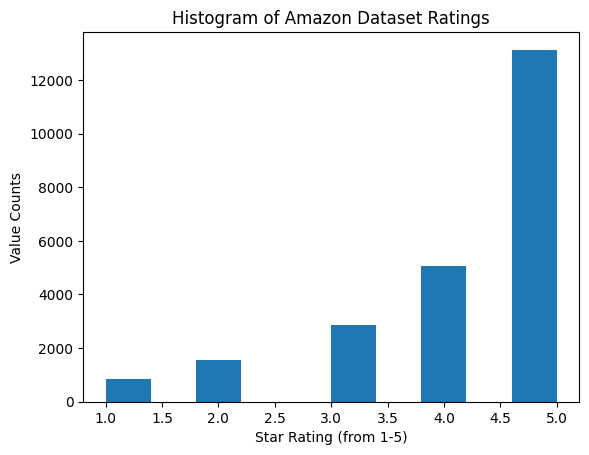

In [24]:
plt.hist(ratings['rating']) # skewed right, lots of five-star reviews, little one-star reviews
plt.ylabel('Value Counts')
plt.xlabel('Star Rating (from 1-5)')
plt.title('Histogram of Amazon Dataset Ratings')

Upon looking at the distribution of star ratings, this explains why support vector machine performs poorly. We have a highly unnbalanced dataset, which is a large weakness of support vector machines. With this type of model, because the soft margin is weak, the decision hyperplanes become skewed towards the minority class when the model is training.

Some ways to mitigate this is to balance the dataset by resampling so that there is an even distribution of ratings or to use class weights that reflect the proportion of each rating in the training dataset.

This was an implementation of sentiment analysis, logistic regression on a dataset to classify text reviews into star ratings, hyperparameter optimization, and some comparison of different classificaation models from a publicily available dataset at: https://www.kaggle.com/datasets/whenamancodes/amazon-reviews-on-women-dresses?resource=download.